In [67]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (6/1.5,7/1.5)
plt.rcParams["figure.dpi"] = 200

In [2]:
import neurenorm

In [4]:
data = neurenorm.load_data("data.tif")

In [133]:
# This returns a list of the different renormalization steps
clusterings = neurenorm.cluster_recursive(data, 9, clustering_strategy='random')
rdata = [neurenorm.apply_clustering(data, clusters) for clusters in clusterings]

In [134]:
def sorted_eigenvals_for_cluster(data, cluster):
    corr_coef = neurenorm.compute_correlation_coefficients(data[cluster])
    eig_vals, _ = np.linalg.eig(corr_coef)
    return -np.sort(-eig_vals)

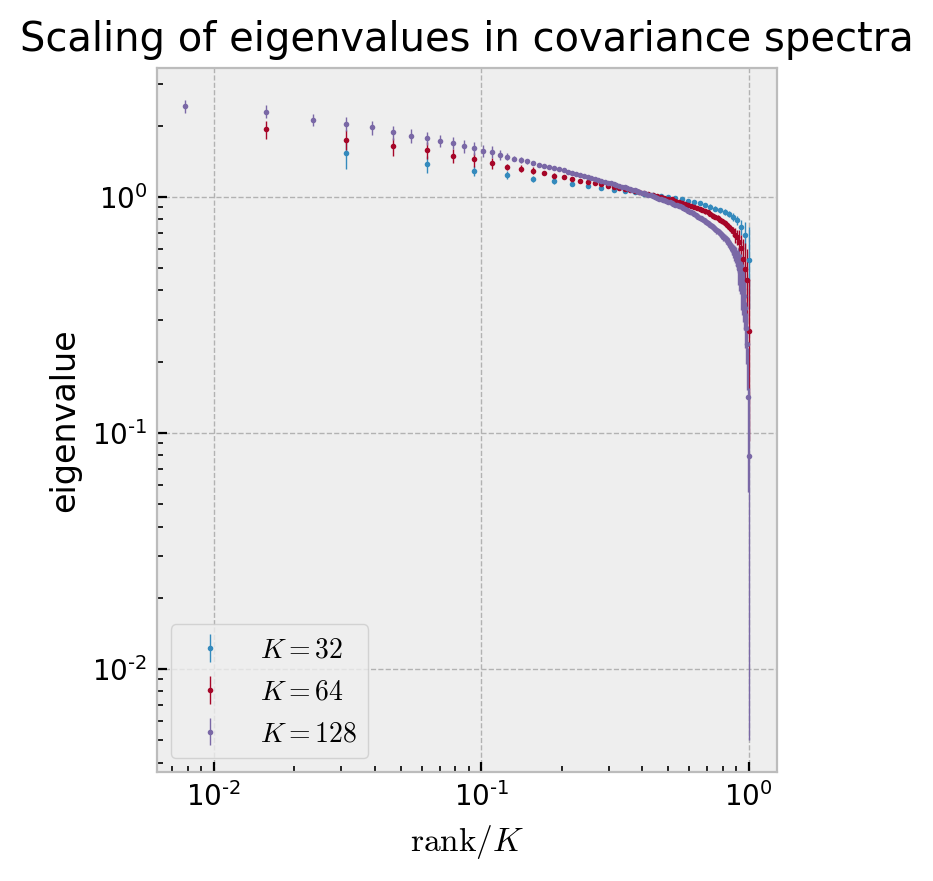

In [135]:
for index in range(5,8):
    clusters = clusterings[index].T
    eigen_vals = np.zeros_like(clusters, float)
    for jdex, cluster in enumerate(clusters):
        eigen_vals[jdex][...] = sorted_eigenvals_for_cluster(data, cluster)
    
    eig_vals_mean = np.mean(eigen_vals, axis=0)
    eig_vals_err = np.std(eigen_vals, axis=0)
        
    x = np.arange(1, len(eig_vals_mean) + 1) / (2**index)
    plt.errorbar(x, eig_vals_mean, yerr=eig_vals_err, fmt='o', markersize=1, elinewidth=0.5, label="$K={}$".format(2**index))

plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\mathrm{rank} / K$')
plt.ylabel('eigenvalue')
plt.title('Scaling of eigenvalues in covariance spectra')
plt.legend(loc=0)
plt.show()

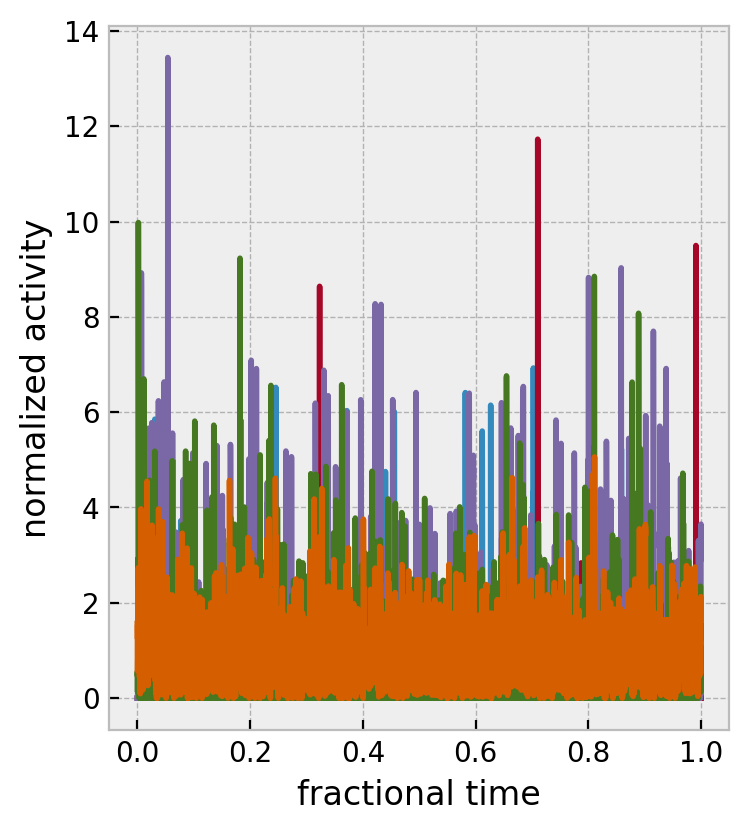

In [136]:
x = np.linspace(0, 1, len(data[0]))

for subdata in rdata[::2]:
    plt.plot(x, subdata[0])
    
plt.xlabel('fractional time')
plt.ylabel('normalized activity')
plt.show()

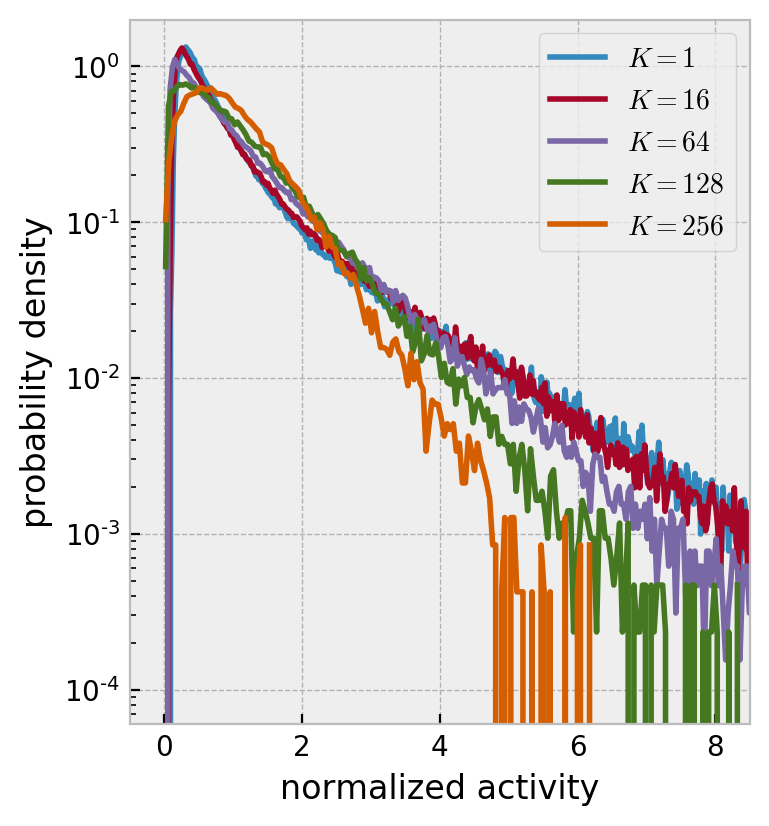

In [137]:
for i in [0, 4, 6, 7, 8]:
    x, y = neurenorm.make_histogram(rdata[i])
    plt.yscale('log')
    plt.xlim(-0.5,8.5)
    plt.plot(x, y, label="$K={}$".format(2**i))
plt.ylabel('probability density')
plt.xlabel('normalized activity')
plt.legend(loc=0)
plt.ylim(0.6*10**-4, 2)
plt.show()

In [138]:
p_zero, p_errs, cluster_sizes = neurenorm.compute_p_trajectory(rdata[:-1])

In [139]:
def neg_log(data):
    return -np.log(data)

In [140]:
# Fitting the exponents to the P_0 curve

f = lambda x, beta, a: -a * np.power(x, beta)
popt, perr = curve_fit(f, cluster_sizes, neg_log(p_zero))

In [141]:
popt, perr

(array([ 0.84413494, -0.04748481]), array([[2.46931359e-04, 6.13654543e-05],
        [6.13654543e-05, 1.54239868e-05]]))

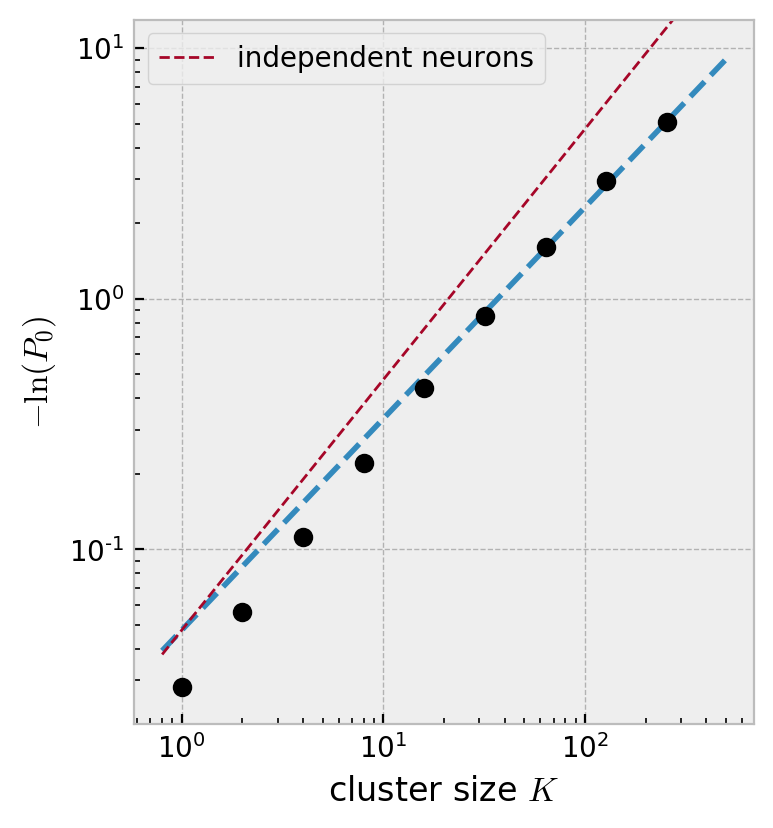

In [142]:
x = np.linspace(.8, 500, 100)
plt.plot(x, f(x, *popt), '--')
plt.plot(x, f(x, 1.0, popt[1]), '--', linewidth=1, label="independent neurons")
plt.errorbar(cluster_sizes, neg_log(p_zero), fmt='ko')
plt.yscale('log')
plt.xscale('log')
plt.ylim(.02, 13)
plt.xlabel('cluster size $K$')
plt.ylabel('$-\ln(P_0)$')
plt.legend()
plt.show()

In [143]:
popt

array([ 0.84413494, -0.04748481])

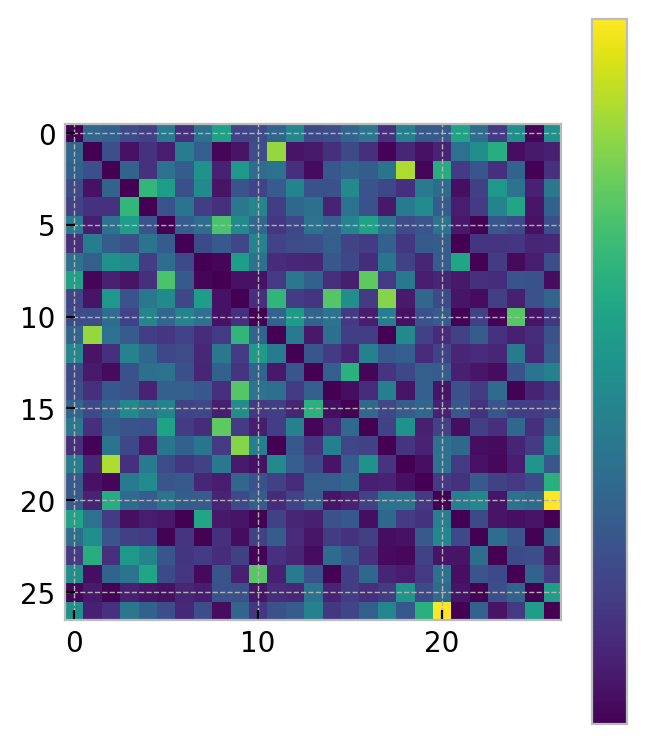

In [144]:
matrix = neurenorm.compute_correlation_coefficients(rdata[5])
matrix = np.abs(matrix - np.identity(len(matrix)))
plt.imshow(matrix, interpolation='nearest')
colorbar = plt.colorbar(ticks = [])